In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sb

In [2]:
%matplotlib inline

In [39]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
                'class']
columns_num = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
columns_cat = ['marital-status', 'occupation', 'relationship', 'race', 'sex'] 
# dropped education as education-num is present

In [4]:
def load_data(directory, file_name, names=None, header=None, skiprows=0):
    return pd.read_csv(os.path.join(directory, file_name), names=names, header=header, skiprows=skiprows, skipinitialspace=True)

In [5]:
def using_model(model, scoring, cv):
    print("****************** {} ******************".format(model))
    if scoring is not None:
        scores_ = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv)
        print("scoring={} cv={}".format(scoring, cv), scores_.mean(), scores_.std())
    model.fit(X_train, y_train)
    global Y_predict
    y_predict = model.predict(X_test)
    print("accuracy_score=", accuracy_score(y_test, y_predict))
    print("precision_score=", precision_score(y_test, y_predict))
    print("recall_score=", recall_score(y_test, y_predict))
    
    

In [6]:
class ColumnDropperTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self
    

    
class ColumnReplacerTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, column, src_texts, rep_with_text):
        self.column = column
        self.src_texts = src_texts
        self.rep_with_text = rep_with_text

    def transform(self, X, y=None):
        X[self.column].replace(self.src_texts, self.rep_with_text, inplace=True)
        return X

    def fit(self, X, y=None):
        return self


In [7]:
base_directory = '~/workspace/personal/datasets/income_predictions'

In [8]:
train = load_data(base_directory, 'adult.data', column_names, None, 0)
test = load_data(base_directory, 'adult.test', names=column_names, skiprows=1)

In [9]:
train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [10]:
for col in train:
    if col in columns_cat:
        #print(adult_data_df.groupby([col]).size(), end='\n-------------\n')
        #adult_data_df.groupby([col]).size().plot(kind='bar')
        print(col)

marital-status
occupation
relationship
race
sex


In [11]:
train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


array([[<AxesSubplot: xlabel='age', ylabel='age'>,
        <AxesSubplot: xlabel='fnlwgt', ylabel='age'>,
        <AxesSubplot: xlabel='education-num', ylabel='age'>,
        <AxesSubplot: xlabel='capital-gain', ylabel='age'>,
        <AxesSubplot: xlabel='capital-loss', ylabel='age'>,
        <AxesSubplot: xlabel='hours-per-week', ylabel='age'>],
       [<AxesSubplot: xlabel='age', ylabel='fnlwgt'>,
        <AxesSubplot: xlabel='fnlwgt', ylabel='fnlwgt'>,
        <AxesSubplot: xlabel='education-num', ylabel='fnlwgt'>,
        <AxesSubplot: xlabel='capital-gain', ylabel='fnlwgt'>,
        <AxesSubplot: xlabel='capital-loss', ylabel='fnlwgt'>,
        <AxesSubplot: xlabel='hours-per-week', ylabel='fnlwgt'>],
       [<AxesSubplot: xlabel='age', ylabel='education-num'>,
        <AxesSubplot: xlabel='fnlwgt', ylabel='education-num'>,
        <AxesSubplot: xlabel='education-num', ylabel='education-num'>,
        <AxesSubplot: xlabel='capital-gain', ylabel='education-num'>,
        <AxesSubpl

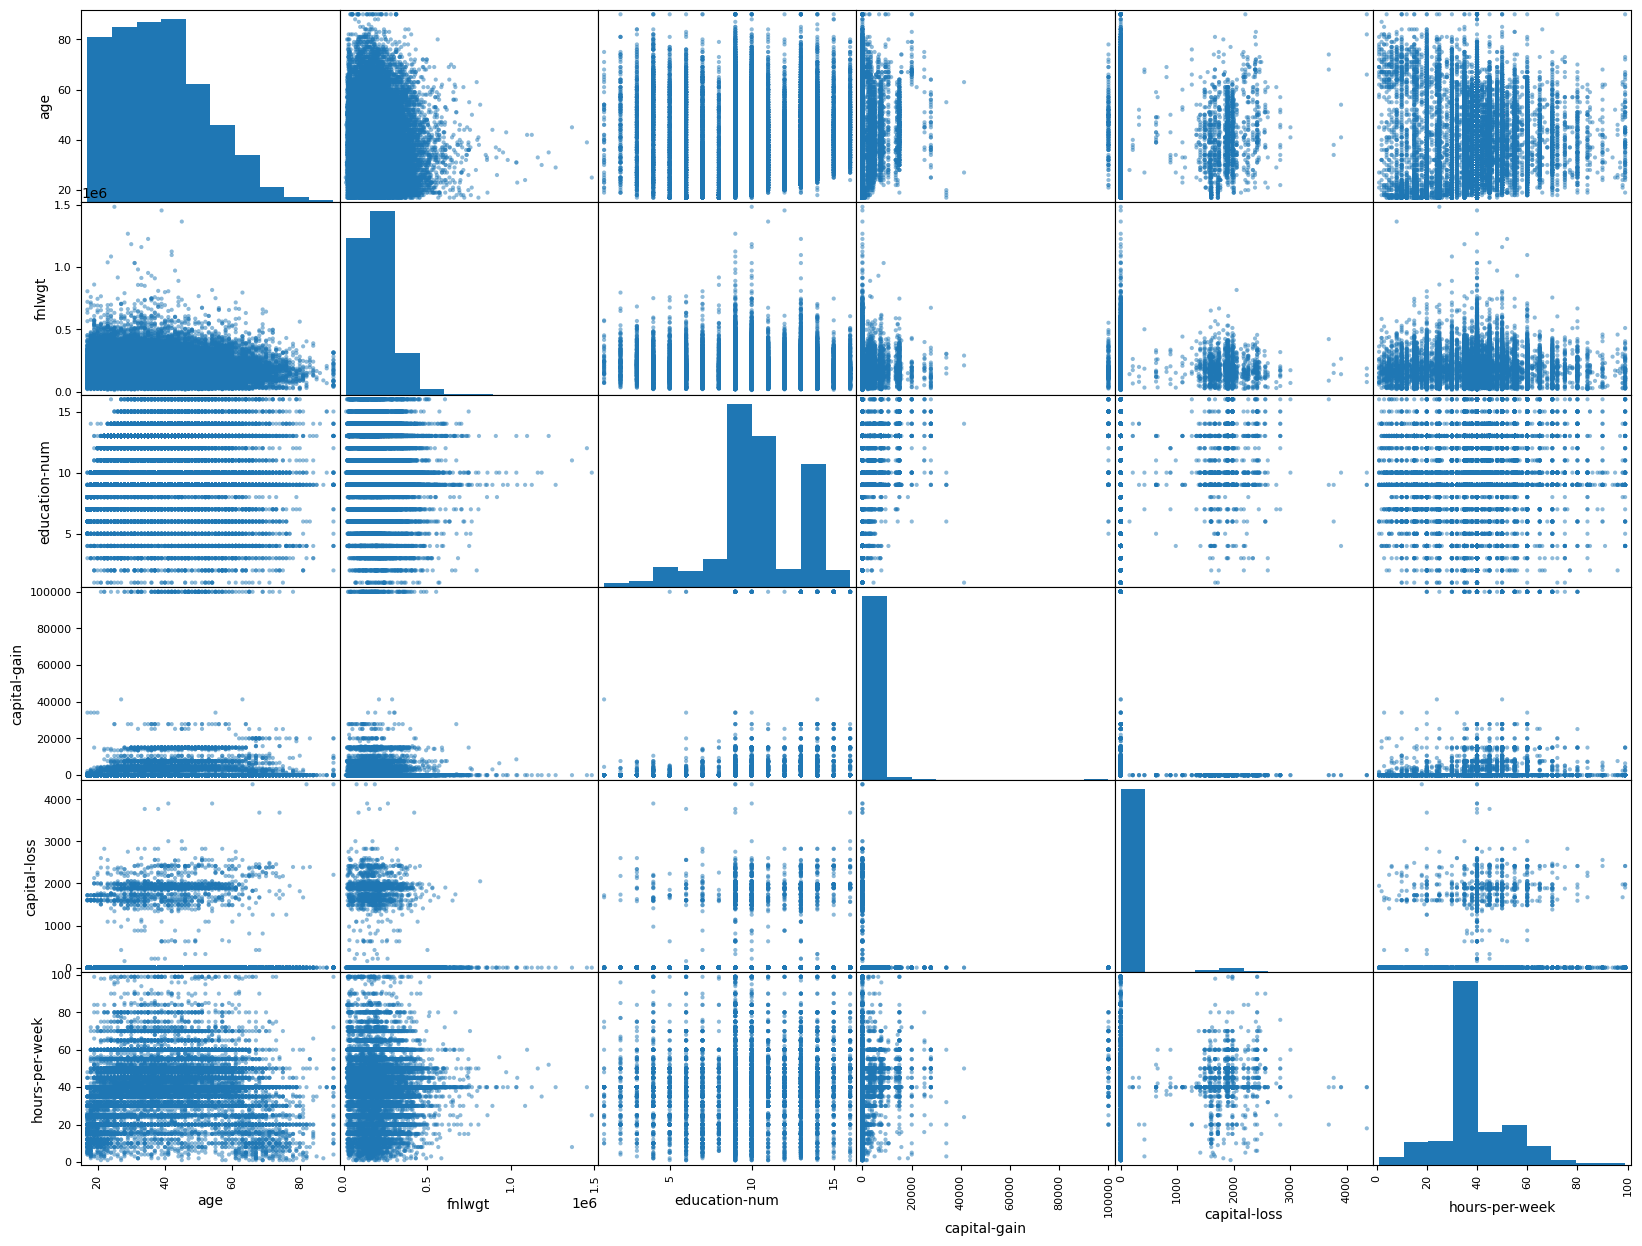

In [12]:
### For only numerical values

scatter_matrix(train, figsize=(20, 15))


<AxesSubplot: >

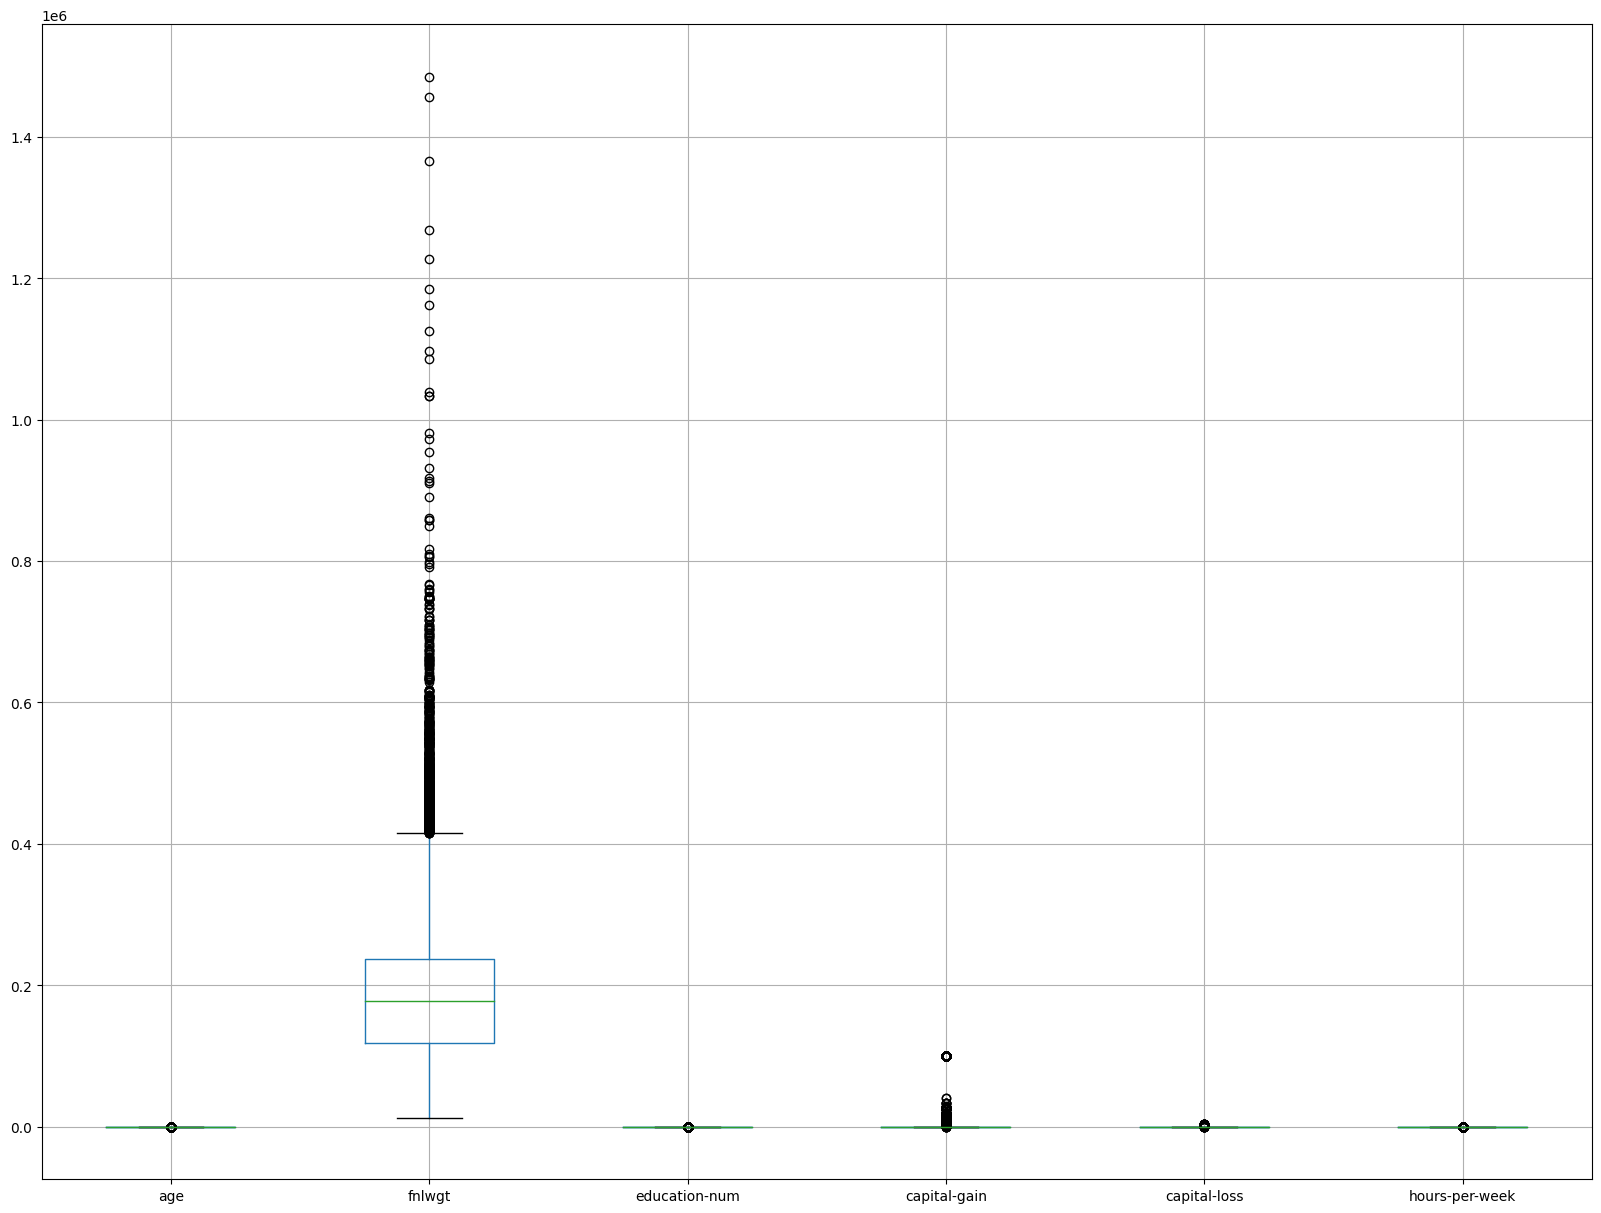

In [38]:
pd.DataFrame(train).boxplot(figsize=(20,15))

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in split.split(train, train["marital-status"]):
        strat_train_set = train.loc[train_index]
        strat_test_set = train.loc[test_index]



array([[<AxesSubplot: xlabel='age', ylabel='age'>,
        <AxesSubplot: xlabel='fnlwgt', ylabel='age'>,
        <AxesSubplot: xlabel='education-num', ylabel='age'>,
        <AxesSubplot: xlabel='capital-gain', ylabel='age'>,
        <AxesSubplot: xlabel='capital-loss', ylabel='age'>,
        <AxesSubplot: xlabel='hours-per-week', ylabel='age'>],
       [<AxesSubplot: xlabel='age', ylabel='fnlwgt'>,
        <AxesSubplot: xlabel='fnlwgt', ylabel='fnlwgt'>,
        <AxesSubplot: xlabel='education-num', ylabel='fnlwgt'>,
        <AxesSubplot: xlabel='capital-gain', ylabel='fnlwgt'>,
        <AxesSubplot: xlabel='capital-loss', ylabel='fnlwgt'>,
        <AxesSubplot: xlabel='hours-per-week', ylabel='fnlwgt'>],
       [<AxesSubplot: xlabel='age', ylabel='education-num'>,
        <AxesSubplot: xlabel='fnlwgt', ylabel='education-num'>,
        <AxesSubplot: xlabel='education-num', ylabel='education-num'>,
        <AxesSubplot: xlabel='capital-gain', ylabel='education-num'>,
        <AxesSubpl

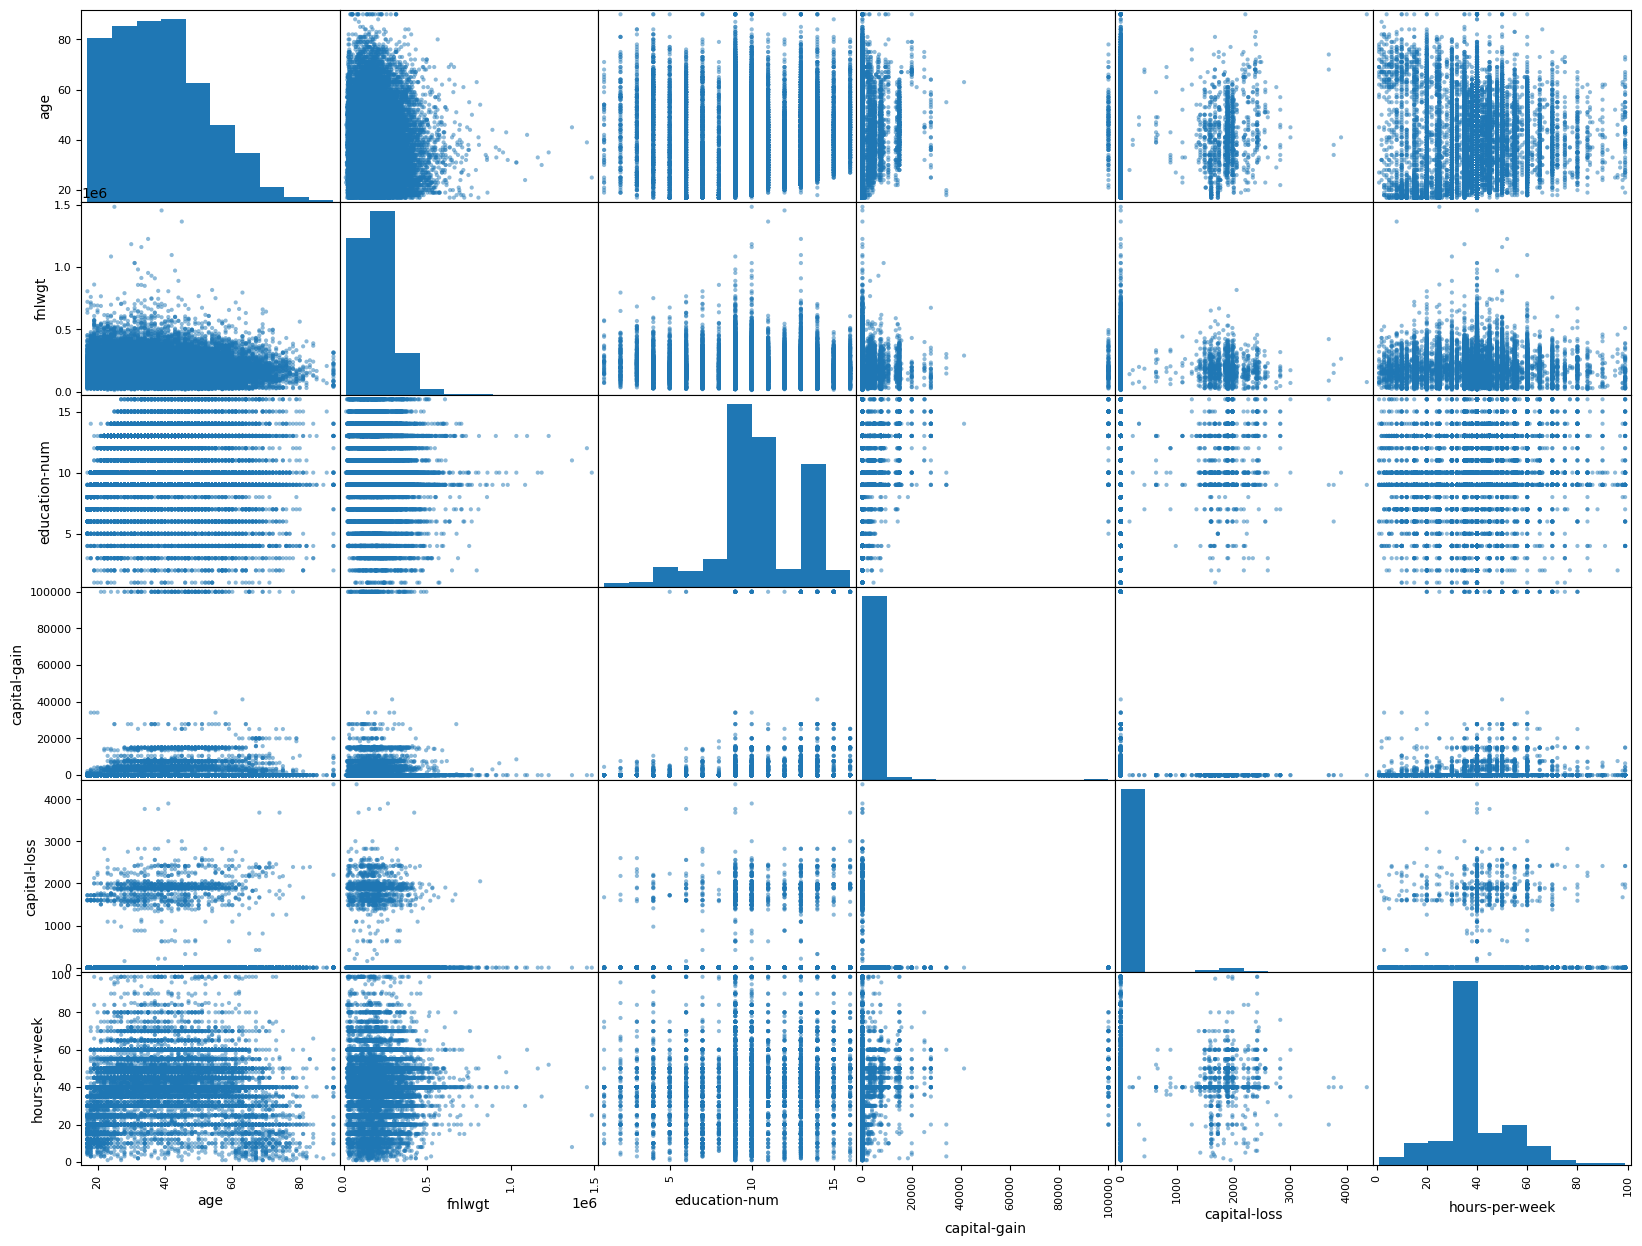

In [15]:
scatter_matrix(strat_train_set, figsize=(20, 15))

In [16]:
train[columns_num].corr().style.background_gradient()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'fnlwgt'}>],
       [<AxesSubplot: title={'center': 'education-num'}>,
        <AxesSubplot: title={'center': 'capital-gain'}>],
       [<AxesSubplot: title={'center': 'capital-loss'}>,
        <AxesSubplot: title={'center': 'hours-per-week'}>]], dtype=object)

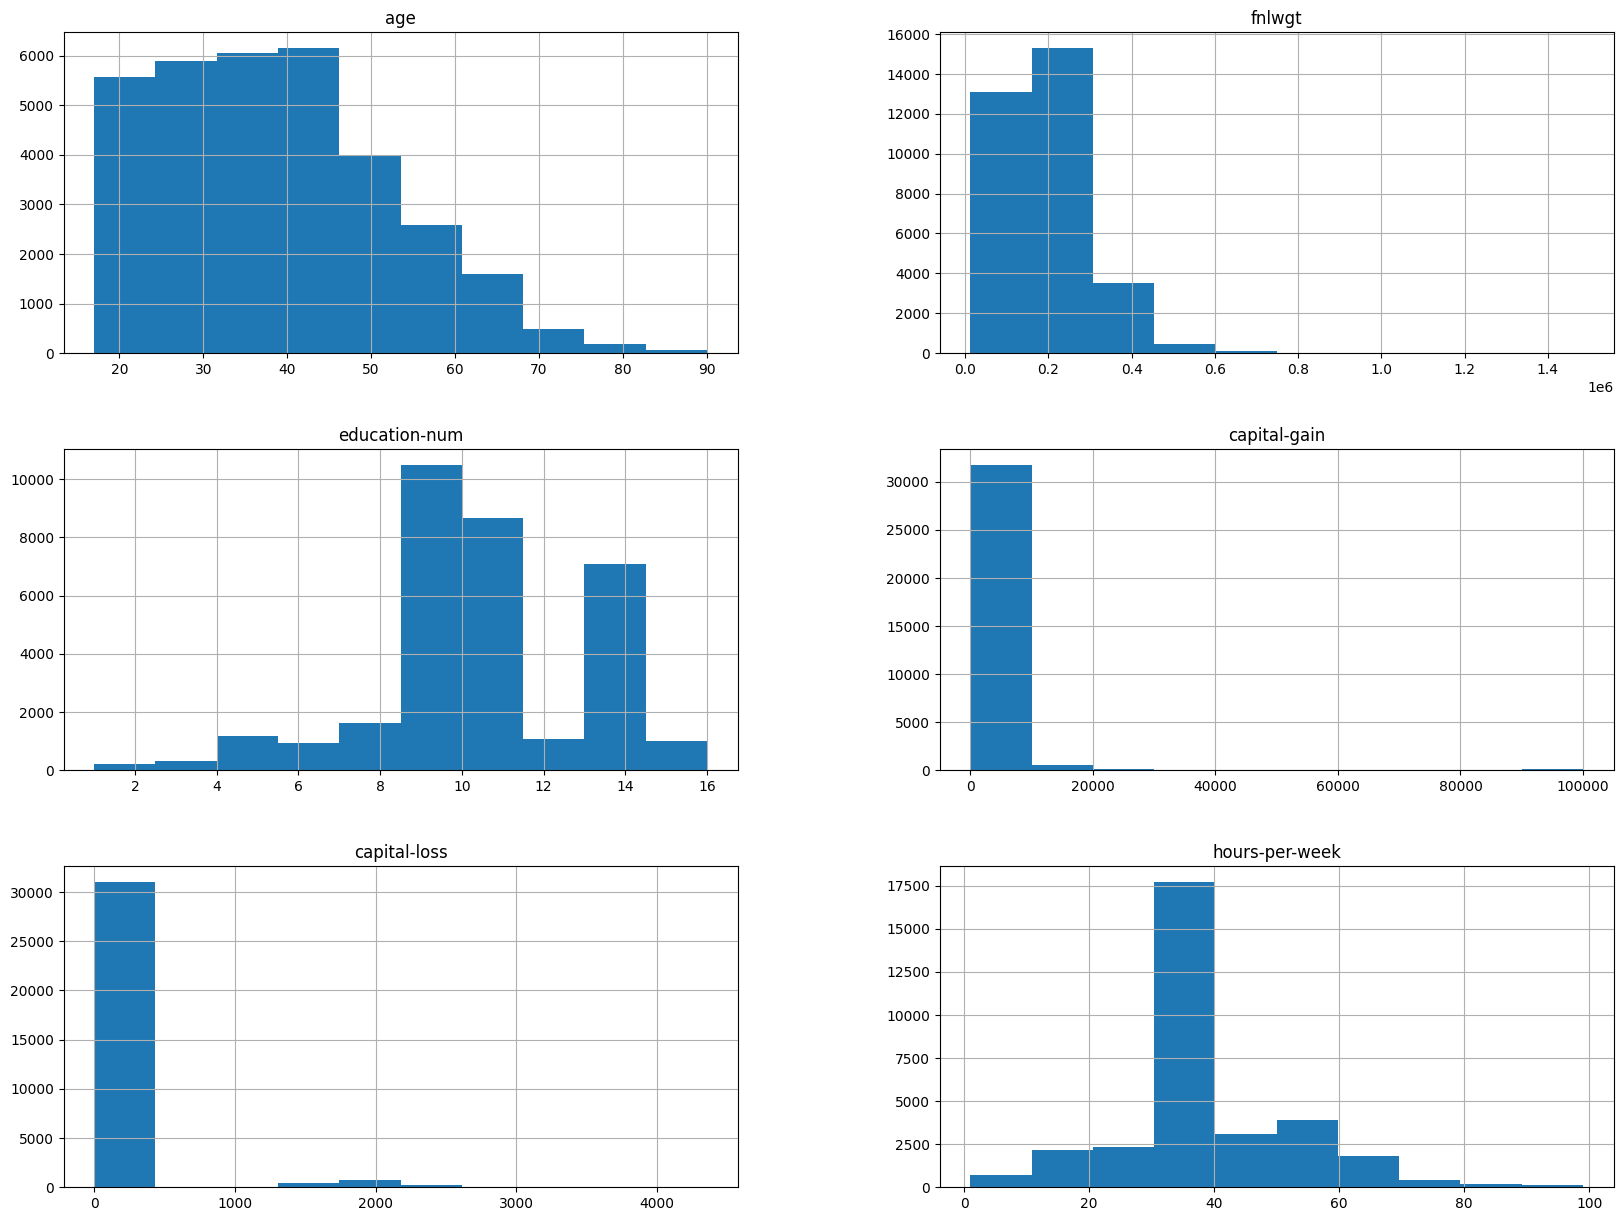

In [17]:
train.hist(figsize=(20,15))

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'fnlwgt'}>],
       [<AxesSubplot: title={'center': 'education-num'}>,
        <AxesSubplot: title={'center': 'capital-gain'}>],
       [<AxesSubplot: title={'center': 'capital-loss'}>,
        <AxesSubplot: title={'center': 'hours-per-week'}>]], dtype=object)

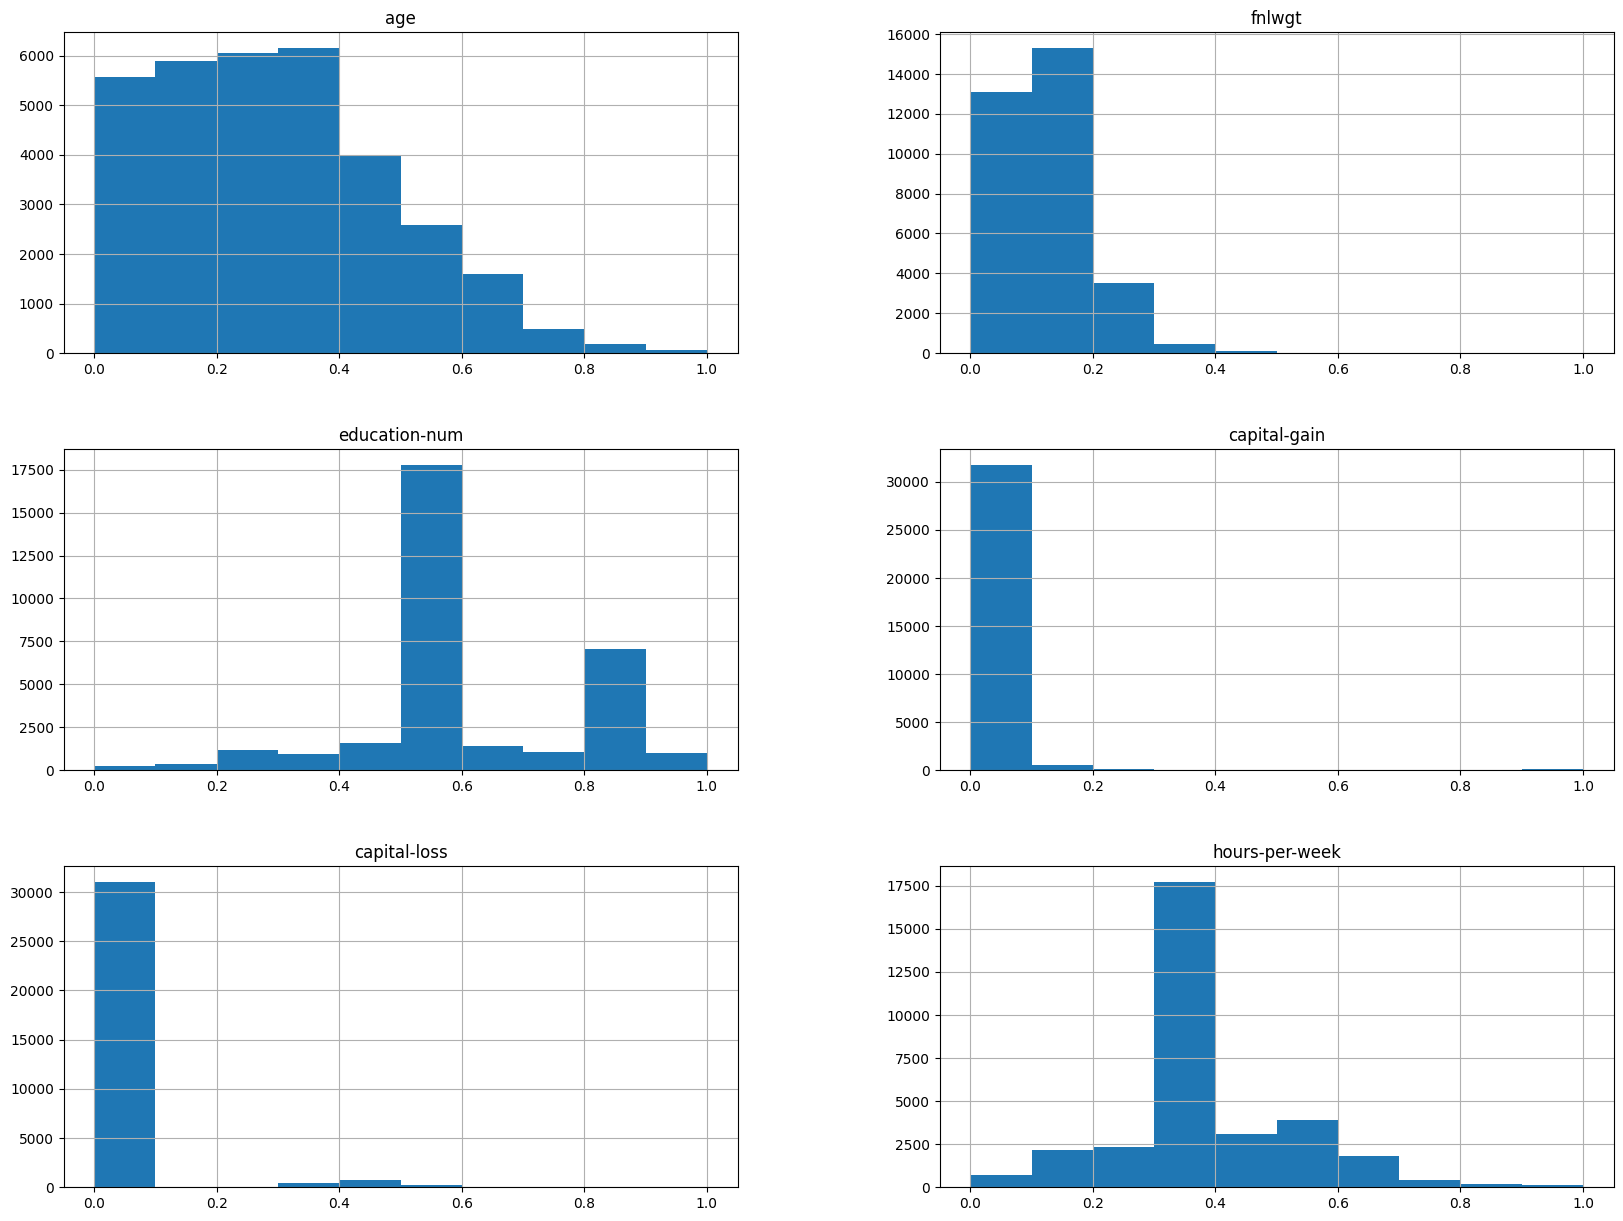

In [18]:
pd.DataFrame(MinMaxScaler().fit_transform(train[columns_num]), columns=columns_num).hist(figsize=(20,15))

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'fnlwgt'}>],
       [<AxesSubplot: title={'center': 'education-num'}>,
        <AxesSubplot: title={'center': 'capital-gain'}>],
       [<AxesSubplot: title={'center': 'capital-loss'}>,
        <AxesSubplot: title={'center': 'hours-per-week'}>]], dtype=object)

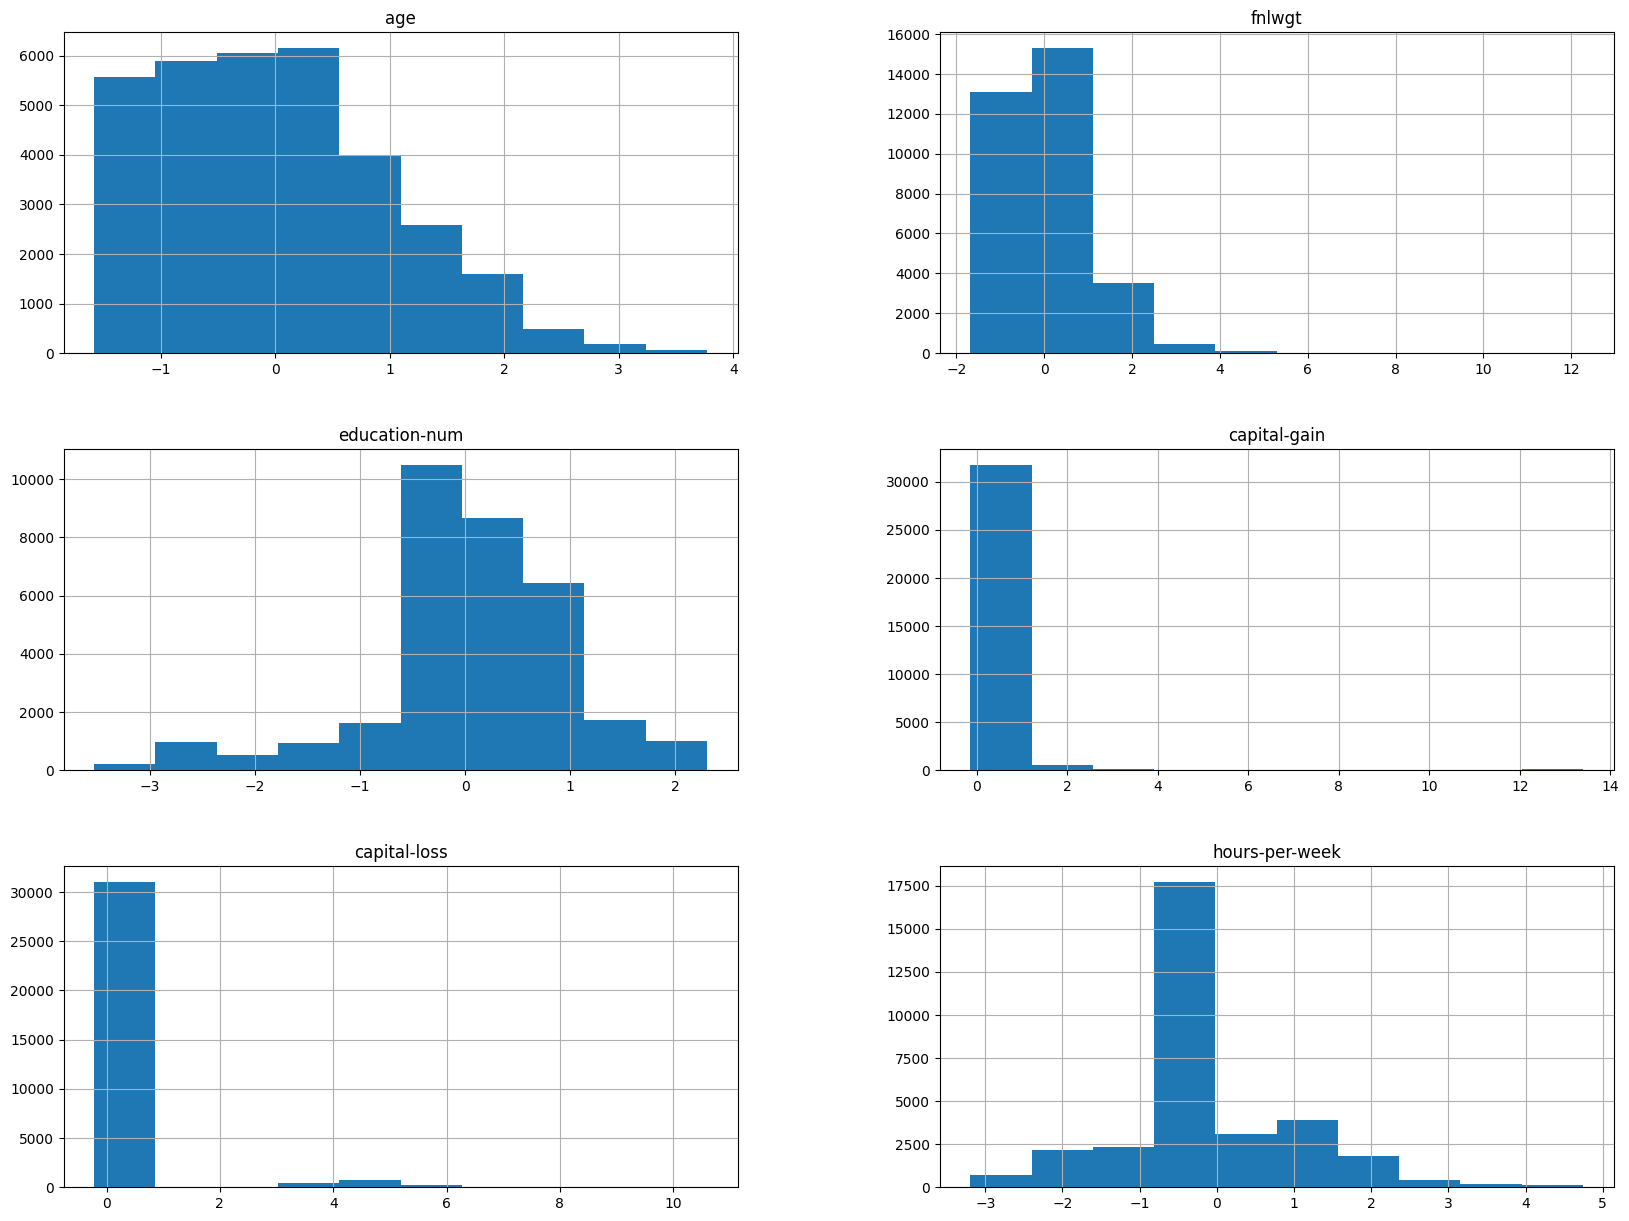

In [19]:
pd.DataFrame(StandardScaler().fit_transform(train[columns_num]), columns=columns_num).hist(figsize=(20,15))

In [20]:
Pipeline([
    ('dropper', ColumnDropperTransformer(['native-country', 'education']))    
]).fit_transform(train)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,class
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,<=50K
32557,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,>50K
32558,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,<=50K
32559,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,<=50K


In [21]:
# Using get_dummies or use binary encoder
pd.get_dummies(train[["race","sex"]], # only selecting 2 cols, else all cols would shown except provided ones
               columns=["race","sex"])


,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0,0,0,0,1,0,1
1,0,0,0,0,1,0,1
2,0,0,0,0,1,0,1
3,0,0,1,0,0,0,1
4,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...
32556,0,0,0,0,1,1,0
32557,0,0,0,0,1,0,1
32558,0,0,0,0,1,1,0
32559,0,0,0,0,1,0,1


In [22]:
_1hot = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [23]:
pd.DataFrame(_1hot.fit_transform(train[["race"]]))

/Users/piyushr/workspace/personal/venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
32556,0.0,0.0,0.0,0.0,1.0
32557,0.0,0.0,0.0,0.0,1.0
32558,0.0,0.0,0.0,0.0,1.0
32559,0.0,0.0,0.0,0.0,1.0


In [24]:
le = LabelEncoder()
pd.DataFrame(le.fit_transform(train[["race"]]))

/Users/piyushr/workspace/personal/venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0
0,4
1,4
2,4
3,2
4,2
...,...
32556,4
32557,4
32558,4
32559,4


In [25]:
train.iloc[:, 0:-1] # X data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [26]:
#train.iloc[:, -1:] # Y data

In [27]:
ct = ColumnReplacerTransformer('occupation', ['Other-services'], 'Other-service')
ct.fit_transform(train)
train['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', '?', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [28]:
preprocess_pipeline = Pipeline([
        ('dropper', ColumnDropperTransformer(['native-country', 'education', 'workclass'])),
        ('unknown_value_replacer', ColumnReplacerTransformer('occupation', ['?'], 'Other-service'))
    ])
train_pre = preprocess_pipeline.fit_transform(train)
train_pre

,age,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,class
0,39,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K
1,50,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K
2,38,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K
3,53,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K
4,28,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,<=50K
32557,40,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,>50K
32558,58,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,<=50K
32559,22,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,<=50K


In [29]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

ct = ColumnTransformer(transformers=[
    ("norm2", num_pipeline, columns_num)
])
preprocess_pipeline = Pipeline([
        ('dropper', ColumnDropperTransformer(['native-country', 'education', 'workclass'])),
        ('unknown_value_replacer', ColumnReplacerTransformer('occupation', ['?'], 'Other-service'))
    ])
train_pre = preprocess_pipeline.fit_transform(train)



ct.fit_transform(train_pre)

array([[ 0.03067056, -1.06361075,  1.13473876,  0.1484529 , -0.21665953,
        -0.03542945],
       [ 0.83710898, -1.008707  ,  1.13473876, -0.14592048, -0.21665953,
        -2.22215312],
       [-0.04264203,  0.2450785 , -0.42005962, -0.14592048, -0.21665953,
        -0.03542945],
       ...,
       [ 1.42360965, -0.35877741, -0.42005962, -0.14592048, -0.21665953,
        -0.03542945],
       [-1.21564337,  0.11095988, -0.42005962, -0.14592048, -0.21665953,
        -1.65522476],
       [ 0.98373415,  0.92989258, -0.42005962,  1.88842434, -0.21665953,
        -0.03542945]])

In [30]:
pd.get_dummies(train_pre[columns_cat])

,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
32557,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
32558,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,1,1,0
32559,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1


In [31]:
X_train = train.drop(labels='class', axis=1)
y_train = train['class']

preprocess_pipeline = Pipeline([
    ('dropper', ColumnDropperTransformer(['native-country', 'education'])),
    ('unknown_value_replacer', ColumnReplacerTransformer('occupation', ['Other-services'], 'Other-service'))
])

X_train = preprocess_pipeline.fit_transform(X_train)

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
X_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, columns_num),
        ("cat", categorical_transformer, columns_cat)
    ]
)

X_train = X_transformer.fit_transform(X_train)
y_train = LabelEncoder().fit_transform(y_train)

# Ready for model

# adult_data_df = preprocess_pipeline.fit_transform(adult_data_df)
# adult_test_df = preprocess_pipeline.fit_transform(adult_test_df)

X_test = test.drop(labels='class', axis=1)
y_test = test['class'].apply(lambda x: x.replace('.', ''))

X_test = preprocess_pipeline.fit_transform(X_test)
X_test = X_transformer.transform(X_test)
y_test = LabelEncoder().fit_transform(y_test)

In [32]:
using_model(SGDClassifier(), "accuracy", 10)

****************** SGDClassifier() ******************
scoring=accuracy cv=10 0.849114136326295 0.005056470717979353
accuracy_score= 0.8453411952582766
precision_score= 0.6799457994579946
recall_score= 0.6523660946437857


## Wrongly predicted class

In [33]:
lg_newton_cg = LogisticRegression(max_iter=500, solver='newton-cg')
using_model(lg_newton_cg, "neg_mean_squared_error", 10)
using_model(lg_newton_cg, "accuracy", 10)

****************** LogisticRegression(max_iter=500, solver='newton-cg') ******************
scoring=neg_mean_squared_error cv=10 -0.14981092509876665 0.005500026685866152
accuracy_score= 0.8519746944290891
precision_score= 0.7253609541745135
recall_score= 0.6008840353614144
****************** LogisticRegression(max_iter=500, solver='newton-cg') ******************
scoring=accuracy cv=10 0.8501890749012334 0.00550002668586614
accuracy_score= 0.8519746944290891
precision_score= 0.7253609541745135
recall_score= 0.6008840353614144


In [34]:
lg_lgbfs = LogisticRegression(max_iter=1000)
using_model(lg_lgbfs, "neg_mean_squared_error", 10)
using_model(lg_lgbfs, "accuracy", 10)

****************** LogisticRegression(max_iter=1000) ******************
scoring=neg_mean_squared_error cv=10 -0.14981092509876665 0.005500026685866152
accuracy_score= 0.8519132731404705
precision_score= 0.7252747252747253
recall_score= 0.6006240249609984
****************** LogisticRegression(max_iter=1000) ******************
scoring=accuracy cv=10 0.8501890749012334 0.00550002668586614
accuracy_score= 0.8519132731404705
precision_score= 0.7252747252747253
recall_score= 0.6006240249609984


In [35]:
using_model(DecisionTreeClassifier(), "neg_mean_squared_error", 10)
using_model(DecisionTreeClassifier(), "accuracy", 10)

****************** DecisionTreeClassifier() ******************
scoring=neg_mean_squared_error cv=10 -0.18559008040893213 0.005468533053036868
accuracy_score= 0.8092868988391376
precision_score= 0.5940116721644253
recall_score= 0.608684347373895
****************** DecisionTreeClassifier() ******************
scoring=accuracy cv=10 0.8141643796502562 0.004920622107347866
accuracy_score= 0.8113752226521712
precision_score= 0.5975333501132646
recall_score= 0.6172646905876235


In [36]:
using_model(RandomForestClassifier(), "accuracy", 10)

****************** RandomForestClassifier() ******************


KeyboardInterrupt: 